In [13]:
# Automatically reload modules before executing code, instead of having to restart kernel
%load_ext autoreload
%autoreload 2

# Setup - Do once (Only in Colab)

In [2]:
try:
    import google.colab
    IN_COLAB = True
    
    from google.colab import drive
    drive.mount('/content/drive')

    import os
    os.chdir('/content/drive/My Drive/Colab Notebooks/RoboAdvisor/notebooks')
    print('Working directory changed to ' + os.getcwd())  

except:
    IN_COLAB = False




In [3]:
if (IN_COLAB):
    !pip install PyPortfolioOpt==0.5.3
    !pip install pandas==0.22.0
    !pip install openpyxl
    !pip install zipline==1.3.0
    !pip install matplotlib==3.1.2
    !pip install deap==1.3.1
    !pip install pyfolio
    !pip install cvxopt
    !pip install yahoofinancials


In [4]:
if (IN_COLAB):
    # Some files need to be modified
    !ls /root
    #!cp setup/extension.py ~/.zipline/extension.py
    !cp ../setup/benchmarks.py /usr/local/lib/python3.6/dist-packages/zipline/data/benchmarks.py
    !cp ../setup/loader.py /usr/local/lib/python3.6/dist-packages/zipline/data/loader.py


## Note: After installing modules, please ensure that you restart the runtime!

In [5]:
import pandas as pd
print("PANDAS: " + pd.__version__)
print("If you do not see 0.22.0, please restart the runtime!")

PANDAS: 0.22.0
If you do not see 0.22.0, please restart the runtime!


# Input and Function definitions

## Core imports and Initialisation

Reference date: 2018-07-21 to 2020-04-03
1 mth ago: 2020-03-05 
1 year ago: 2019-04-04 
2 year ago: 2018-07-21


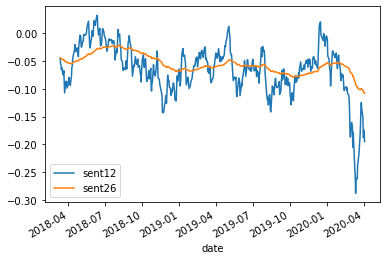

In [1]:
import sys
sys.path.append('..')  # add parent folder to sys path

import pickle
import pandas as pd
from datetime import datetime, timedelta
from collections import OrderedDict
from zipline.utils.calendars import get_calendar
import pytz

from algorithms import run, CRBAlgorithm, OptAlgorithm, TradingSignalAlgorithm, BuyAndHoldAlgorithm
from utils import plot_rolling_returns_from_perf_array, print_table_from_perf_array
from ga import saw_ga_trading_fn, smpt_ga_trading_fn

timezone = 'US/Mountain'
calendar = 'NYSE'
bundle_name = 'robo-advisor_US'
capital_base = 1000000

tz = pytz.timezone(timezone)
tc = get_calendar(calendar)

# boundaries of our dataset for stocks and sentiments
start_date = '2018-07-21'
end_date = '2020-04-03'

# define start and end intervals for backtesting
start_bt = tz.localize(datetime.strptime(start_date, '%Y-%m-%d'))
end_bt = tz.localize(datetime.strptime(end_date, '%Y-%m-%d'))
# bt_30_days_c = bt_end - pd.Timedelta(days=30)  # 30 calendar days ago

# Assume approx trading days per year = 252, approx trading days per month = 252/12 = 21
tyear = 252
tmth = 21
start_1mth = tc.sessions_window(end_date, -tmth)[0]  
start_1year = tc.sessions_window(end_date, -tyear)[0] 
start_2year = tc.sessions_window(end_date, -2*tyear)[0] 

start_2year = max(start_bt, start_2year) # cannot be before our dateset start-date

print(f"Reference date: {start_date} to {end_date}")
print(f"1 mth ago: {start_1mth:%Y-%m-%d} \n1 year ago: {start_1year:%Y-%m-%d} \n2 year ago: {start_2year:%Y-%m-%d}")

# Load sentiments dataset
filepath='../data/twitter/sentiments_overall_daily.csv'
social_media = pd.read_csv(filepath, usecols=['date', 'buzz', 'finBERT', 'sent12', 'sent26'])
social_media['date'] = pd.to_datetime(social_media['date'], format="%Y-%m-%d", utc=True)
social_media.set_index('date', inplace=True, drop=True)

social_media[['sent12', 'sent26']].plot()

# Update Portfolio Details

In [23]:
dir_path = "../../frontend/smartportfolioWeb/src/smartportfolioWeb/"
file_path = dir_path + "portfolio_details.xlsx"
df = pd.read_excel(file_path, dtype={'model': str, 'benchmark': str}, keep_default_na=False)

trade_freq = 'monthly'
toUpdate = True

def updateReturns(t, s, obj, w_file, social_media):
    grp = ""
    subgrp = ""
    
    if s == "SPDR":
        grp = "SPDR"
        subgrp = "ALL_SECTORS"
        stocks = ['XLE', 'XLRE', 'XLF', 'XLV', 'XLC', 'XLI', 'XLY', 'XLP', 'XLB', 'XLK', 'XLU']
    elif s == "ALL_WEATHER":
        grp = "DALIO"
        subgrp = "ALL_WEATHER"
        stocks = ['VTI', 'TLT', 'IEF', 'GLD', 'DBC']
    elif s == "SPY":
        grp = "BENCHMARK"
        subgrp = "SPY"        
        stocks = ['SPY']
        
    w = None
    if w_file != "":
        with open(f"output/{w_file}.pickle", "rb+") as f:
            top10 = pickle.load(f)    
            best = top10[0]
    
    if t == "CRB":
        algo = CRBAlgorithm(verbose=False, grp=grp, subgrp=subgrp, rebalance_freq=trade_freq)
    
    
    elif t in ["MPT", "HRP"]:        
        algo = OptAlgorithm(verbose=False, grp=grp, subgrp=subgrp,
                            collect_before_trading=False, history=500, objective=obj,
                            rebalance_freq=trade_freq)
        
    elif t == "SAW":        
        w = OrderedDict()
        i = 0
        for s in stocks:
            w[s] = {"p": best[i], "n": best[i+1]}
            i = i + 2

        algo = TradingSignalAlgorithm(verbose=False, grp=grp, subgrp=subgrp,
                                  collect_before_trading=False, history=500,
                                  rebalance_freq=trade_freq, trading_signal=saw_ga_trading_fn,
                                  initial_weights=[0.3, 0.4, 0.15, 0.075, 0.075], normalise_weights=True,
                                  **{"weights": w, "social_media": social_media})
    elif t == "SMPT":        
        w = best
        algo = OptAlgorithm(verbose=False, grp=grp, subgrp=subgrp,
                    collect_before_trading=False, history=500, objective=obj,
                    rebalance_freq=trade_freq, mpt_adjustment=smpt_ga_trading_fn, 
                    **{"weights": w, "social_media": social_media})
        
    elif t == "BAH":
        algo = BuyAndHoldAlgorithm(verbose=False, grp=grp, subgrp=subgrp)

        
    bt_1mth = run("1mth", algo, bundle_name, start_1mth, end_bt, capital_base, analyze=False)
    bt_1year = run("1year", algo, bundle_name, start_1year, end_bt, capital_base, analyze=False)
    # bt_2year = run("2year", algo, bundle_name, start_2year, end_bt, capital_base, analyze=False)
    bt_all = run("All", algo, bundle_name, start_bt, end_bt, capital_base, analyze=False)    

    return bt_1mth, bt_1year, bt_all

perf_stats = {}
details_pref = {}
index_to_pid = {}

for index, row in df.iterrows():
    t = row['type'].upper()
    s = row['stocks'].upper()
    obj = row['criteria'].lower()
    w_file = row['model']
    pid = row['id']
    
    print(t, s, obj, w_file)
    bt_1mth, bt_1year, bt_all = updateReturns(t, s, obj, w_file, social_media)
    
    index_to_pid[index] = pid
    details_pref[pid] = (bt_1mth, bt_1year, bt_all)    
    perf_stats[pid] = print_table_from_perf_array([bt_1mth, bt_1year, bt_all], show_header=False)
    

MPT SPDR max_sharpe 


,1mth,1year,All
Annual return,-91.187%,-11.175%,-5.954%
Cumulative returns,-18.324%,-11.175%,-9.9%
Annual volatility,101.213%,32.29%,26.177%
Sharpe ratio,-1.91,-0.21,-0.10
Calmar ratio,-3.02,-0.32,-0.17
Stability,0.35,0.05,0.18
Max drawdown,-30.218%,-34.992%,-34.993%
Omega ratio,0.74,0.95,0.97
Sortino ratio,-2.62,-0.28,-0.14
Skew,0.31,-0.06,-0.11


MPT SPDR min_volatility 


,1mth,1year,All
Annual return,-89.887%,-11.314%,-5.32%
Cumulative returns,-17.382%,-11.314%,-8.866%
Annual volatility,89.48%,29.082%,23.674%
Sharpe ratio,-2.12,-0.27,-0.11
Calmar ratio,-3.22,-0.33,-0.16
Stability,0.39,0.03,0.30
Max drawdown,-27.902%,-33.874%,-33.873%
Omega ratio,0.72,0.93,0.97
Sortino ratio,-2.82,-0.36,-0.15
Skew,0.15,-0.31,-0.40


HRP SPDR hrp 


,1mth,1year,All
Annual return,-88.564%,-15.894%,-7.73%
Cumulative returns,-16.531%,-15.894%,-12.771%
Annual volatility,89.853%,29.708%,24.91%
Sharpe ratio,-1.97,-0.43,-0.20
Calmar ratio,-3.40,-0.45,-0.22
Stability,0.34,0.01,0.20
Max drawdown,-26.039%,-35.067%,-35.069%
Omega ratio,0.73,0.90,0.96
Sortino ratio,-2.57,-0.56,-0.26
Skew,-0.05,-0.94,-0.97


CRB ALL_WEATHER crb 


,1mth,1year,All
Annual return,14.2%,9.936%,8.07%
Cumulative returns,1.113%,9.936%,14.089%
Annual volatility,3.878%,10.279%,8.64%
Sharpe ratio,3.44,0.97,0.94
Calmar ratio,2158.48,0.69,0.56
Stability,0.13,0.71,0.84
Max drawdown,-0.007%,-14.351%,-14.351%
Omega ratio,170.14,1.23,1.21
Sortino ratio,585.92,1.25,1.23
Skew,4.25,-2.11,-2.10


MPT ALL_WEATHER max_sharpe 


,1mth,1year,All
Annual return,-35.105%,12.588%,4.266%
Cumulative returns,-3.539%,12.588%,7.352%
Annual volatility,26.6%,11.143%,12.485%
Sharpe ratio,-1.50,1.12,0.40
Calmar ratio,-2.94,0.99,0.21
Stability,0.02,0.82,0.28
Max drawdown,-11.932%,-12.694%,-20.259%
Omega ratio,0.77,1.25,1.08
Sortino ratio,-1.88,1.50,0.53
Skew,-0.43,-1.19,-0.66


SAW ALL_WEATHER max_ret SAW_GA_MAX_RET_best


,1mth,1year,All
Annual return,14.344%,21.549%,16.662%
Cumulative returns,1.123%,21.549%,29.919%
Annual volatility,3.908%,12.13%,10.145%
Sharpe ratio,3.45,1.67,1.57
Calmar ratio,3099.37,1.81,1.40
Stability,0.14,0.77,0.92
Max drawdown,-0.005%,-11.889%,-11.889%
Omega ratio,243.72,1.38,1.34
Sortino ratio,840.81,2.46,2.32
Skew,4.25,-0.17,-0.13


SAW ALL_WEATHER min_vol SAW_GA_MIN_VOL_p200_g5_s244


,1mth,1year,All
Annual return,11.168%,11.886%,8.941%
Cumulative returns,0.886%,11.886%,15.656%
Annual volatility,3.091%,5.769%,5.1%
Sharpe ratio,3.44,1.98,1.70
Calmar ratio,1962.85,1.86,1.42
Stability,0.13,0.82,0.90
Max drawdown,-0.006%,-6.393%,-6.314%
Omega ratio,156.76,1.46,1.36
Sortino ratio,539.57,2.74,2.38
Skew,4.25,-1.17,-1.00


SMPT ALL_WEATHER max_sharpe SMPT_GA_MAX_RET_p200_g5_s2020


,1mth,1year,All
Annual return,-26.585%,11.375%,3.853%
Cumulative returns,-2.543%,11.375%,6.632%
Annual volatility,18.881%,8.063%,9.887%
Sharpe ratio,-1.55,1.38,0.43
Calmar ratio,-3.04,1.28,0.19
Stability,0.02,0.84,0.28
Max drawdown,-8.751%,-8.9%,-20.632%
Omega ratio,0.77,1.28,1.08
Sortino ratio,-1.93,1.87,0.57
Skew,-0.48,-1.12,-0.75


BAH SPDR bah 
Buying 2018 shares of Equity(11 [XLE])
Buying 2320 shares of Equity(16 [XLRE])
Buying 3437 shares of Equity(12 [XLF])
Buying 930 shares of Equity(18 [XLV])
Buying 1793 shares of Equity(10 [XLC])
Buying 1243 shares of Equity(13 [XLI])
Buying 780 shares of Equity(19 [XLY])
Buying 1465 shares of Equity(15 [XLP])
Buying 1654 shares of Equity(9 [XLB])
Buying 1000 shares of Equity(14 [XLK])
Buying 1343 shares of Equity(17 [XLU])
Buying 1368 shares of Equity(11 [XLE])
Buying 2506 shares of Equity(16 [XLRE])
Buying 3422 shares of Equity(12 [XLF])
Buying 994 shares of Equity(18 [XLV])
Buying 1886 shares of Equity(10 [XLC])
Buying 1183 shares of Equity(13 [XLI])
Buying 778 shares of Equity(19 [XLY])
Buying 1640 shares of Equity(15 [XLP])
Buying 1571 shares of Equity(9 [XLB])
Buying 1203 shares of Equity(14 [XLK])
Buying 1579 shares of Equity(17 [XLU])
Buying 1219 shares of Equity(11 [XLE])
Buying 2805 shares of Equity(16 [XLRE])
Buying 3253 shares of Equity(12 [XLF])
Buying 1045 sh

,1mth,1year,All
Annual return,-90.14%,-17.492%,-9.142%
Cumulative returns,-17.557%,-17.492%,-15.027%
Annual volatility,91.896%,30.205%,24.959%
Sharpe ratio,-2.07,-0.48,-0.26
Calmar ratio,-3.26,-0.49,-0.26
Stability,0.36,0.00,0.15
Max drawdown,-27.656%,-36.004%,-35.77%
Omega ratio,0.72,0.88,0.94
Sortino ratio,-2.69,-0.63,-0.34
Skew,-0.01,-0.84,-0.89


BAH ALL_WEATHER bah 
Buying 1955 shares of Equity(7 [VTI])
Buying 2523 shares of Equity(6 [TLT])
Buying 1258 shares of Equity(4 [IEF])
Buying 476 shares of Equity(3 [GLD])
Buying 5430 shares of Equity(2 [DBC])
Buying 2040 shares of Equity(7 [VTI])
Buying 3229 shares of Equity(6 [TLT])
Buying 1419 shares of Equity(4 [IEF])
Buying 614 shares of Equity(3 [GLD])
Buying 4652 shares of Equity(2 [DBC])
Buying 2067 shares of Equity(7 [VTI])
Buying 3353 shares of Equity(6 [TLT])
Buying 1474 shares of Equity(4 [IEF])
Buying 646 shares of Equity(3 [GLD])
Buying 4411 shares of Equity(2 [DBC])


,1mth,1year,All
Annual return,-51.569%,11.468%,8.45%
Cumulative returns,-5.863%,11.468%,14.771%
Annual volatility,30.292%,10.495%,8.811%
Sharpe ratio,-2.24,1.09,0.97
Calmar ratio,-3.54,0.82,0.60
Stability,0.09,0.76,0.84
Max drawdown,-14.552%,-14.068%,-13.998%
Omega ratio,0.69,1.25,1.21
Sortino ratio,-2.70,1.42,1.27
Skew,-0.62,-1.84,-1.80


BAH SPY bah 
Buying 3306 shares of Equity(5 [SPY])
Buying 3482 shares of Equity(5 [SPY])
Buying 3568 shares of Equity(5 [SPY])


,1mth,1year,All
Annual return,-85.949%,-12.795%,-6.401%
Cumulative returns,-15.087%,-12.795%,-10.627%
Annual volatility,87.948%,29.821%,25.336%
Sharpe ratio,-1.80,-0.31,-0.13
Calmar ratio,-3.49,-0.37,-0.19
Stability,0.30,0.04,0.24
Max drawdown,-24.635%,-34.245%,-34.241%
Omega ratio,0.75,0.93,0.97
Sortino ratio,-2.38,-0.40,-0.18
Skew,-0.01,-0.78,-0.76


In [75]:
for index, row in df.iterrows():
    pid = index_to_pid[index]
    df.loc[index, '30 days returns'] = perf_stats[pid]['1mth']['Annual return'].replace("%", "")
    df.loc[index, '30 days max drawdown'] = perf_stats[pid]['1mth']['Max drawdown'].replace("%", "")
    df.loc[index, '1 yr returns'] = perf_stats[pid]['1year']['Annual return'].replace("%", "")
    df.loc[index, '1 yr max drawdown'] = perf_stats[pid]['1mth']['Max drawdown'].replace("%", "")
    df.loc[index, 'all returns'] = perf_stats[pid]['All']['Annual return'].replace("%", "")
    df.loc[index, 'all max drawdown'] = perf_stats[pid]['All']['Max drawdown'].replace("%", "")
    
    # Use all data of backtesting results to calculate annual Value-at-risk (VAR)
    ret, pos, trans = pf.utils.extract_rets_pos_txn_from_zipline(details_pref[pid][2][1])
    
    avar = value_at_risk(ret, period='yearly', sigma=2.326) * 100
    df.loc[index, 'annual 99%-var'] = f"{avar:.3f}"
    
    # Use annual VAR to classify risk into low, medium and high. 
    # The disadvantage of using VAR is that the portfolio might keep switching class with time
    if (avar > -10):
        risk = 'low'
    elif (avar > -20):
        risk = 'medium'
    elif (avar > -30):
        risk = 'medium-high'
    else:
        risk = 'high'
    df.loc[index, 'risk'] = risk
        
df[:]

,id,name,description,type,stocks,criteria,sentiment,model,market,risk,benchmark,30 days returns,30 days max drawdown,1 yr returns,1 yr max drawdown,all returns,all max drawdown,annual 99%-var
0,mpt_spdr_max_sharpe,Sector-based MPT (max sharpe),Utilise Modern Portfolio Theory (MPT) to get t...,MPT,SPDR,max_sharpe,no,,US,high,"spy, spdr",-91.187,-30.218,-11.175,-30.218,-5.954,-34.993,-42.105
1,mpt_spdr_min_volatility,Sector-based MPT (min volatility),Utilise Modern Portfolio Theory (MPT) to get t...,MPT,SPDR,min_volatility,no,,US,high,"spy, spdr",-89.887,-27.902,-11.314,-27.902,-5.32,-33.873,-53.407
2,hrp_spdr_hrp,Sector-based HRP,Utilise Hierarchical Risk Parity (HRP) to get ...,HRP,SPDR,hrp,no,,US,high,"spy, spdr",-88.564,-26.039,-15.894,-26.039,-7.73,-35.069,-62.257
3,crb_all_weather_crb,All-Weather,"This simplified all-weather portfolio, by Ray ...",CRB,ALL_WEATHER,crb,no,,US,medium,"spy, all_weather",14.2,-0.007,9.936,-0.007,8.07,-14.351,-19.184
4,mpt_all_weather_max_sharpe,All-Weather MPT (Max Sharpe),Utilise Modern Portfolio Theory (MPT) to get ...,MPT,ALL_WEATHER,max_sharpe,no,,US,high,"spy, all_weather",-35.105,-11.932,12.588,-11.932,4.266,-20.259,-31.039
5,saw_all_weather_max_ret,Sentimental All-Weather (Max Returns),Utilises Twitter Sentiments as trading signals...,SAW,ALL_WEATHER,max_ret,yes,SAW_GA_MAX_RET_best,US,low,"spy, all_weather",14.344,-0.005,21.549,-0.005,16.662,-11.889,-2.344
6,saw_all_weather_min_vol,Sentimental All-Weather (Min Volatility),Utilises Twitter Sentiments as trading signals...,SAW,ALL_WEATHER,min_vol,yes,SAW_GA_MIN_VOL_p200_g5_s244,US,low,"spy, all_weather",11.168,-0.006,11.886,-0.006,8.941,-6.314,-6.398
7,smpt_all_weather_max_sharpe,Sentimental All-Weather MPT (Max Sharpe),Utilise Modern Portfolio Theory (MPT) with sen...,SMPT,ALL_WEATHER,max_sharpe,yes,SMPT_GA_MAX_RET_p200_g5_s2020,US,medium-high,"spy, all_weather",-26.585,-8.751,11.375,-8.751,3.853,-20.632,-29.444
8,bah_spdr_bah,Buy-and-Hold SPDR,Buy-and-Hold equally-weighted 11 SPDR sector ETFs,BAH,SPDR,bah,no,,US,high,,-90.14,-27.656,-17.492,-27.656,-9.142,-35.77,-62.084
9,bah_all_weather_bah,Buy-and-Hold All-Weather,Buy-and-Hold All-Weather portfolio with 30% st...,BAH,ALL_WEATHER,bah,no,,US,medium,,-51.569,-14.552,11.468,-14.552,8.45,-13.998,-17.639


In [76]:
df.to_excel(file_path, index=False)

import pickle
with open(dir_path + "portfolio_details.pickle", "wb+") as f:
    pickle.dump(perf_stats, f)

with open(dir_path + "portfolio_graph.pickle", "wb+") as f:
    pickle.dump(details_pref, f)

# Some data analytics

## Get performance for a specific id

In [36]:
id = 'mpt_all_weather_max_sharpe'
_ = print_table_from_perf_array(details_pref[pid], show_header=False)

,1mth,1year,All
Annual return,-35.105%,12.588%,4.266%
Cumulative returns,-3.539%,12.588%,7.352%
Annual volatility,26.6%,11.143%,12.485%
Sharpe ratio,-1.50,1.12,0.40
Calmar ratio,-2.94,0.99,0.21
Stability,0.02,0.82,0.28
Max drawdown,-11.932%,-12.694%,-20.259%
Omega ratio,0.77,1.25,1.08
Sortino ratio,-1.88,1.50,0.53
Skew,-0.43,-1.19,-0.66


In [54]:
import pyfolio as pf
# from pyfolio.timeseries import value_at_risk
# value_at_risk(details_pref[pid][1][1]['algorithm_period_return'])
ret, pos, trans = pf.utils.extract_rets_pos_txn_from_zipline(details_pref[pid][1][1])
print("Annual 95%-VAR", value_at_risk(ret, period="yearly", sigma=1.645) * 100)
print("Annual 99%-VAR", value_at_risk(ret, period="yearly", sigma=2.326) * 100)


Annual 95%-VAR 2.919614381295351
Annual 99%-VAR 1.596277137495667


2019-04-04 00:00:00+00:00    0.000000
2019-04-05 00:00:00+00:00   -0.000036
2019-04-08 00:00:00+00:00   -0.000186
2019-04-09 00:00:00+00:00   -0.003821
2019-04-10 00:00:00+00:00    0.004100
2019-04-11 00:00:00+00:00   -0.001473
2019-04-12 00:00:00+00:00    0.003376
2019-04-15 00:00:00+00:00   -0.000010
2019-04-16 00:00:00+00:00   -0.001295
2019-04-17 00:00:00+00:00   -0.002732
2019-04-18 00:00:00+00:00    0.002391
2019-04-22 00:00:00+00:00   -0.000955
2019-04-23 00:00:00+00:00    0.008196
2019-04-24 00:00:00+00:00    0.000920
2019-04-25 00:00:00+00:00   -0.001627
2019-04-26 00:00:00+00:00    0.004961
2019-04-29 00:00:00+00:00   -0.000408
2019-04-30 00:00:00+00:00    0.001267
2019-05-01 00:00:00+00:00   -0.005269
2019-05-02 00:00:00+00:00   -0.003938
2019-05-03 00:00:00+00:00    0.007434
2019-05-06 00:00:00+00:00   -0.000874
2019-05-07 00:00:00+00:00   -0.011129
2019-05-08 00:00:00+00:00   -0.001729
2019-05-09 00:00:00+00:00   -0.001918
2019-05-10 00:00:00+00:00    0.002893
2019-05-13 0

## Compare performance for different time frames

In [13]:
pref_1mth = []
pref_1yr = []
pref_all = []
for k, v in details_pref.items():
    pref_1mth.append((k, v[0][1]))
    pref_1yr.append((k, v[1][1]))
    pref_all.append((k, v[2][1]))
# _ = print_table_from_perf_array(pref_1mth, show_header=False)

In [15]:
# Sort by performance (cumulative returns)
pref_1mth.sort(key=lambda x: x[1]['algorithm_period_return'][-1].item(), reverse=True)
pref_1yr.sort(key=lambda x: x[1]['algorithm_period_return'][-1].item(), reverse=True)
pref_all.sort(key=lambda x: x[1]['algorithm_period_return'][-1].item(), reverse=True)

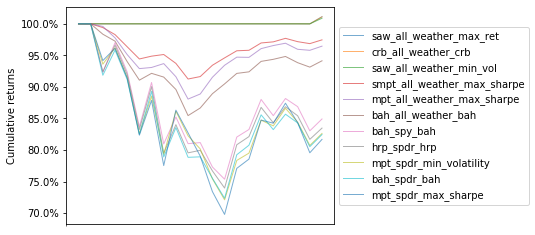

In [16]:
plot_rolling_returns_from_perf_array(pref_1mth, None)

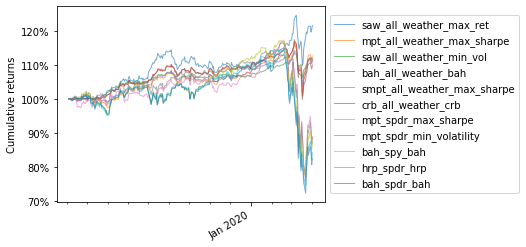

In [17]:
plot_rolling_returns_from_perf_array(pref_1yr, None)

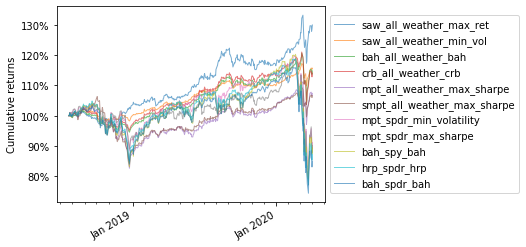

In [18]:
plot_rolling_returns_from_perf_array(pref_all, None)

In [35]:
from bs4 import BeautifulSoup as b
pid = "mpt_all_weather_max_sharpe"
# perf_stats[pid]

portfolio_data = df[df['id']==pid]
# print(portfolio_data['benchmark'])

print(portfolio_data['benchmark'])

# p_benchmarks = [f"bah_{x.strip()}_bah" for x in portfolio_data['benchmark'][0].split(',')]
# print(p_benchmarks)

# soup = bs(perf_stats[pid].to_html(), 'html.parser')


4    spy, all_weather
Name: benchmark, dtype: object
